# Face Keypoints Detection with Keras

In this notebook, I am going to train a deep learning model to predict face landmarks using [re-annotated LFPW](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/) for training and validation.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os
import math
from pathlib import Path
from os.path import join, exists
from datetime import datetime
from itertools import chain, islice, cycle

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from swissknife.files import FilesStream
from swissknife.utils import calculate_layout
from basedir import LFPW_TRAIN, LFPW_VALID, MODELS_FOLDER

In [7]:
# Global variables
RANDOM_STATE = 1
NUM_OF_LANDMARKS = 68

Setting a random generator seed helps to get repeatable results in cases when the process of random selection or data shuffling is performed, or in any other algorithm that involves random numbers generation.

In [8]:
np.random.seed(RANDOM_STATE)

## The Dataset

As usual, the data loading and preparation processes are the very first steps in any machine learning pipeline. In our case, we have two arrays of data:
1. Face photos
2. Files with landmarks in PTS format

Therefore, when training the model, our objective will be to iterate through the folder with data, loading images and their landmarks.

### First Glance

Let's now load a couple of data examples to understand how the raw data looks like: 

In [9]:
def read_landmarks(filename, one_based_index=True):
    """
    Reads file in PTS format into two arrays with x and y
    landmarks positions.
    
    The implementation is based on analogous Menpo library function.
    """
    with open(filename) as file:
        lines = [line.strip() for line in file]
        
    line = lines[0]
    while not line.startswith('{'):
        line = lines.pop(0)
        
    xs, ys = [], []
    for line in lines:
        if line.strip().startswith('}'):
            continue
        x, y = line.split()[:2]
        xs.append(x)
        ys.append(y)
        
    offset = 1 if one_based_index else 0
    xs = np.array(xs, dtype=np.float) - offset
    ys = np.array(ys, dtype=np.float) - offset
    return xs, ys

In [10]:
def imread(filename):
    """Reads an image into RGB array format."""
    return cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)

In [11]:
def preview_image_with_landmarks(file_id, dataset=LFPW_TRAIN):
    """
    Shows a single image from the training dataset with face landmarks 
    alongside with its landmarks.
    """
    image_path = join(dataset, f'{file_id}.png')
    pts_path = join(dataset, f'{file_id}.pts')
    assert exists(image_path) and exists(pts_path)
    
    xs, ys = read_landmarks(pts_path)
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
    ax.imshow(imread(image_path))
    ax.set_axis_off()
    return fig

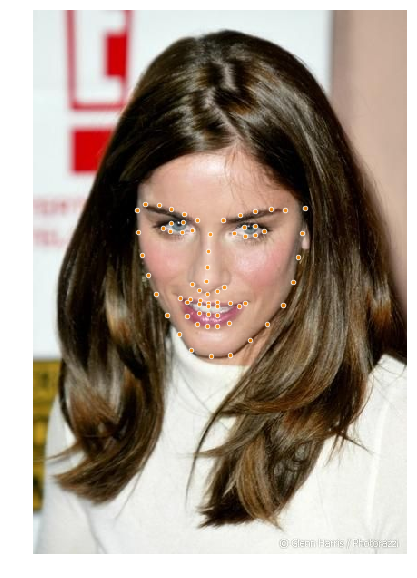

In [12]:
_ = preview_image_with_landmarks('image_0001')

Great, the picture above shows that landmarks reading function correctly reads the landmarks locations, and can be used to parse dataset files. 

Now let's pick a few more images to see if the dataset samples are represented in the same resolution. Also, it would help us to get some understanding of the dataset images quality, illumination, and so forth.

In [13]:
def read_files(root, ext):
    return sorted([
        join(root, filename)
        for filename in os.listdir(root)
        if filename.endswith(f'.{ext}')
    ])

In [14]:
def preview_random_subset_of_images(num_of_samples, n_cols=4, dataset=LFPW_TRAIN):
    """
    Loads a `num_of_samples` images from the dataset and renders them on a single canvas.
    """
    all_images = read_files(dataset, 'png')
    all_points = read_files(dataset, 'pts')
    
    n = len(all_images)
    index = np.random.choice(n, size=num_of_samples)
    
    n_rows, n_cols = calculate_layout(num_of_samples, n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()

    for idx, ax in zip(index, axes):
        img = imread(all_images[idx])
        xs, ys = read_landmarks(all_points[idx])
        ax.imshow(img)
        ax.scatter(xs, ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
        ax.set_title(f'shape: {img.shape[0]}x{img.shape[1]}')
    
    return fig

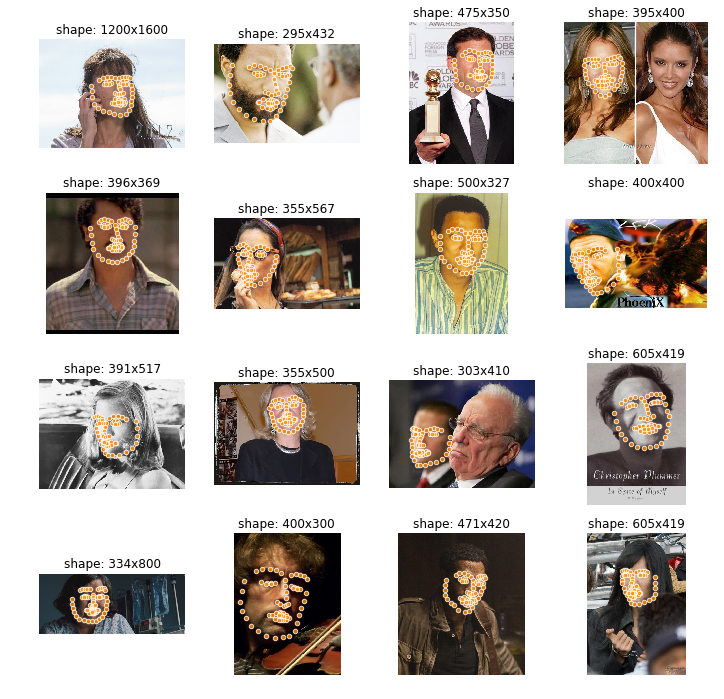

In [15]:
_ = preview_random_subset_of_images(16)

A more thorough investigation shows that the dataset observations are quite different from each other. Some of them even show more then one face! Moreover, the images include a lot of information that is note required to predict face landmarks, like, backgrounds, necks, shoulders, an so on. We only need face rectangles.

Therefore, our next step is to "normalize" the dataset samples to make them ready for a deep model training.

### Images Cropping

It is simple to crop the image from the testing dataset: the positions of landmarks are known in advance and we only need to find a bounding box rectangle using these landmarks points.

In [16]:
def read_single_sample(file_id, dataset=LFPW_TRAIN):
    img = join(dataset, f'{file_id}.png')
    pts = join(dataset, f'{file_id}.pts')
    xs, ys = read_landmarks(pts)
    return imread(img), np.r_[xs, ys]

In [17]:
def split_xy(landmarks):
    n = len(landmarks) // 2
    return landmarks[:n], landmarks[n:]

In [18]:
def crop(image, landmarks, padding=None):
    """
    Crops image to contain only a region of face with landmarks with 
    optional padding region.
    """
    xs, ys = split_xy(landmarks.copy())
    bbox = [xs.min(), ys.min(), xs.max(), ys.max()]
    if padding is not None:
        bbox[0] -= padding
        bbox[1] -= padding
        bbox[2] += padding
        bbox[3] += padding
    left, top, right, bottom = [int(max(0, x)) for x in bbox]
    cropped = image[top:bottom, left:right, :]
    xs -= left
    ys -= top
    new_landmarks = np.r_[xs, ys]
    return cropped, new_landmarks

In [19]:
def show(image, landmarks):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    xs, ys = split_xy(landmarks)
    ax.imshow(image)
    ax.scatter(xs, ys, color='darkorange', edgecolor='white', s=20, alpha=0.8)
    ax.set_axis_off()

In [20]:
img, landmarks = read_single_sample('image_0001')

In [21]:
crop_img, crop_pts = crop(img, landmarks, padding=20)

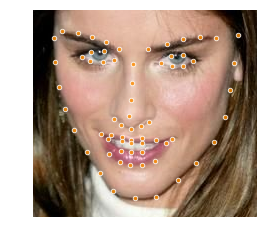

In [22]:
show(crop_img, crop_pts)

Now we have an image that contains a face and its landmarks only. However, in general, each cropped image still has a different resolution. We should implement a function that could rescale the image and its landmarks to some specific shape.

### Rescaling Cropped Images

In [23]:
def resize(image, landmarks, target_size):
    """
    Rescales image and its landmarks without keeping originl aspect ratio.
    """
    image = np.copy(image)
    new_image = cv.resize(image, target_size)
    
    old_h, old_w = image.shape[:2]
    new_h, new_w = new_image.shape[:2]
    w_ratio = new_w / float(old_w)
    h_ratio = new_h / float(old_h)
    n = landmarks.shape[0] // 2
    
    new_landmarks = np.zeros_like(landmarks)
    for i in range(0, n):
        new_landmarks[i] = landmarks[i] * w_ratio
        new_landmarks[i + n] = landmarks[i + n] * h_ratio
    
    return new_image, new_landmarks

In [24]:
def preview_random_subset_of_processed_images(num_of_samples, n_cols=4, dataset=LFPW_TRAIN):
    """
    Loads a `num_of_samples` images from the dataset, applies a set of preprocessing 
    functions and renders the result on a single canvas.
    """
    all_images = read_files(dataset, 'png')
    all_points = read_files(dataset, 'pts')
    
    n = len(all_images)
    index = np.random.choice(n, size=num_of_samples)
    
    n_rows, n_cols = calculate_layout(num_of_samples, n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()

    for idx, ax in zip(index, axes):
        img = imread(all_images[idx])
        xs, ys = read_landmarks(all_points[idx])
        landmarks = np.r_[xs, ys]
        cropped = crop(img, landmarks, padding=10)
        resized_img, resized_landmarks = resize(*cropped, (120, 120))

        new_xs, new_ys = split_xy(resized_landmarks)
        new_shape = resized_img.shape
        ax.imshow(resized_img)
        ax.scatter(new_xs, new_ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
        ax.set_title(f'shape: {new_shape[0]}x{new_shape[1]}')
    
    return fig

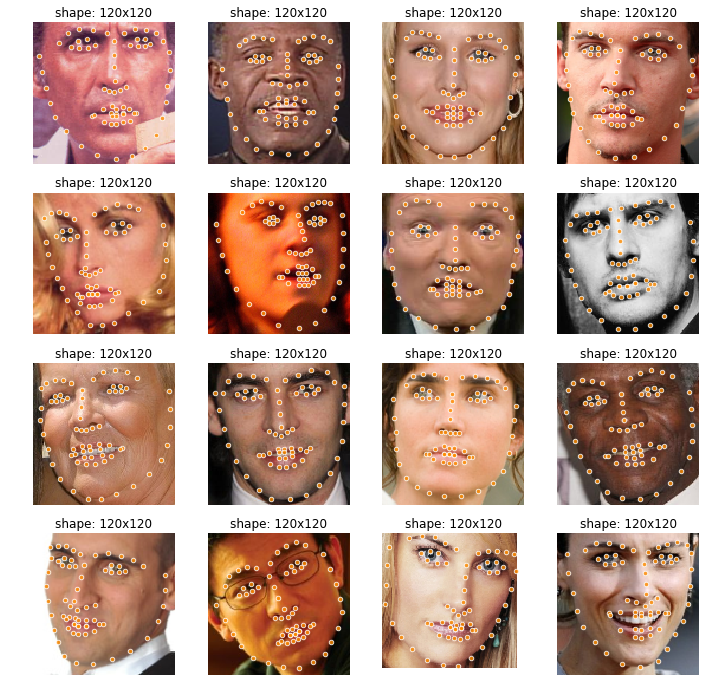

In [25]:
_ = preview_random_subset_of_processed_images(16)

Ok, now we have a an array of the same shape cropped images and ready to start building a deep learning model.

---
## The Model

We've prepared a set of utilities to transform images but a couple more steps are required to build a high-quality training dataset. We need to join all these scripts into a **data transformation pipeline** that would traverse the folder with the training data, yielding paths to images and landmarks files, read them into `NumPy` arrays, and rescale to an appropriate shapes. 

As soon as we're going to train a deep learning model, it would be a really good idea to apply **data augmentation techniques** to the training images making the model more robust to the noise. Also, probably we don't need color channels to accomplish our goal because face landmarks positions doesn't change if the face is represented as an RGB image or a grayscale one but reducing the number of channels in images will make the training process faster.

Generally speaking, we would like to pass each dataset observation through the following sequence of steps before showing to the model:

1. Crop face regions
2. Resize images to the common shape
3. Convert to grayscale
4. Apply data augmentation operations


### Sanity Checks 

At the very beginning, let's create a utility to verify that data processing steps don't damage our data:

In [26]:
def show_images(images, landmarks, n_cols=4, cmap=None):
    n_rows, n_cols = calculate_layout(len(images), n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()

    for ax in axes:
        ax.set_axis_off()
        
    for img, pts, ax in zip(images, landmarks, axes):
        xs, ys = split_xy(pts)
        if img.shape[-1] == 1:
            img = img.reshape(img.shape[0], img.shape[1])
            cmap = 'gray'
        ax.imshow(img, cmap=cmap)
        ax.set_title(img.shape)
        ax.scatter(xs, ys, color='darkorange', edgecolor='white', s=20)

### Reading Files in Batches

A deep learning model training is usually performed using batch optimization algorithms: we don't show all the data at once but split the dataset into smaller chunks. The `AnnotatedImagesStream` class is intended to read images and their landmarks from a hard drive and yield them in batches to the caller.

In [27]:
class AnnotatedImagesStream:
    """
    Yields batches of image and annotation files from a dataset root folder.
    """
    def __init__(self,
                 root: str,
                 batch_size: int=32,
                 infinite: bool=False,
                 same_size_batches: bool=False,
                 images_ext: str='jpg|jpeg|png',
                 points_ext: str='pts'):

        self.root = root
        self.batch_size = batch_size
        self.infinite = infinite
        self.same_size_batches = same_size_batches
        self.images_files = glob_extensions(self.root, images_ext)
        self.points_files = glob_extensions(self.root, points_ext)

        if not infinite and same_size_batches:
            raise ValueError('Incompatible configuration: cannot guarantee '
                             'same size of batches when yielding finite '
                             'number of files.')

        pairs = list(zip(self.images_files, self.points_files))
        for img_name, pts_name in pairs:
            assert Path(img_name).stem == Path(pts_name).stem

        n_files = len(pairs)
        if same_size_batches:
            n_batches = n_files // batch_size
        else:
            n_batches = int(math.ceil(n_files / batch_size))

        self._n_batches = n_batches
        self._iter = cycle(pairs) if infinite else iter(pairs)
        self._count = 0

    @property
    def n_batches(self):
        return self._n_batches

    def __iter__(self):
        return self

    def __next__(self):
        if not self.infinite and self._count >= self._n_batches:
            raise StopIteration()
        item = self.next()
        self._count += 1
        return item

    def next(self):
        bs = self.batch_size
        if self.infinite and self._count == self._n_batches:
            self._iter = iter(list(zip(self.images_files, self.points_files)))
            self._count = 0
        x_batch, y_batch = zip(*[xy for xy in islice(self._iter, 0, bs)])
        return x_batch, y_batch


def glob_extensions(folder, extensions):
    folder = Path(folder)
    return sorted([
        path.as_posix()
        for path in chain(*[
            folder.glob('*.' + ext)
            for ext in parse_extensions(extensions)])])


def parse_extensions(string):
    return string.split('|') if '|' in string else [string]

Next, we need to convert the filenames into `NumPy` arrays:

In [28]:
class FilesReader:
    
    def __init__(self, target_size, padding):
        self.target_size = target_size
        self.padding = padding
        
    def __call__(self, x_batch, y_batch):
        images, landmarks = [], []
        for img_file, pts_file in zip(x_batch, y_batch):
            img = imread(img_file)
            xs, ys = read_landmarks(pts_file)
            pts = np.r_[xs, ys]
            cropped = crop(img, pts, padding=self.padding)
            new_img, new_pts = resize(*cropped, target_size=self.target_size)
            images.append(new_img)
            landmarks.append(new_pts)
        return np.array(images), np.array(landmarks)

In [29]:
def to_grayscale(x_batch, y_batch):
    """
    We ignore landmarks because their positions are not affected by 
    converting image into another color space.
    """
    n, w, h = x_batch.shape[:3]
    grayscaled = np.zeros((n, w, h, 1))
    for i, image in enumerate(x_batch):
        new_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        grayscaled[i, :] = new_image.reshape((w, h, 1))
    return grayscaled, y_batch

Let's check if our classes works as expected and convert file names into numerical arrays with predefiened shapes:

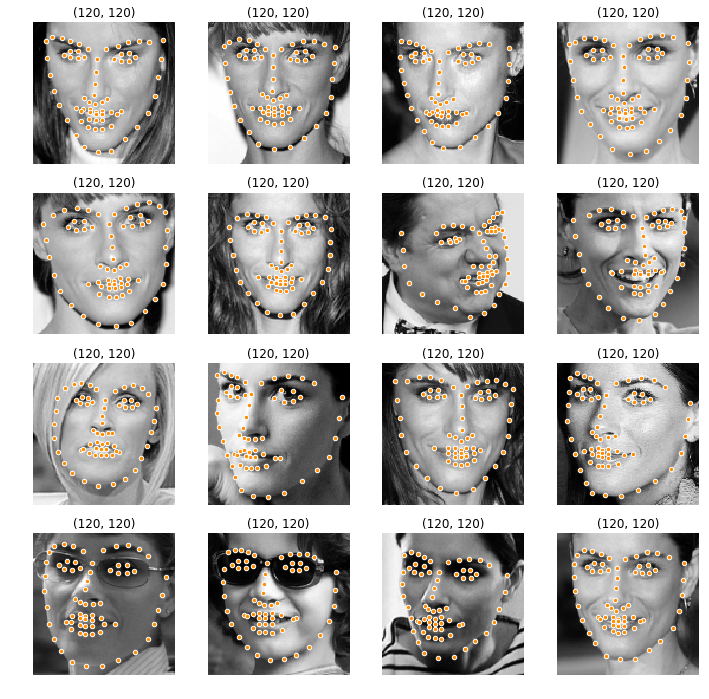

In [30]:
stream = AnnotatedImagesStream(root=LFPW_TRAIN, batch_size=16)
reader = FilesReader(target_size=(120, 120), padding=20)
x_batch, y_batch = next(stream)
img, pts = to_grayscale(*reader(x_batch, y_batch))
show_images(img, pts)

### Data Augmentation

In [31]:
class RandomAugmentationMixin:
    
    def __init__(self, probability=0.5):
        self.probability = probability
        
    def apply(self, image, landmarks):
        if self.probability >= np.random.rand():
            new_image, new_landmarks = image.copy(), landmarks.copy()
            return self._apply(new_image, new_landmarks)
        else:
            return image, landmarks
        
    def _apply(self, image, landmarks):
        raise NotImplementedError()

In [32]:
class AffineTransformation(RandomAugmentationMixin):
    
    def __init__(self, matrix, **kwargs):
        super().__init__(**kwargs)
        assert matrix.shape == (2, 3)
        self.matrix = matrix
        
    @property
    def rotation(self):
        return self.matrix[:2, :2]
    
    @property
    def shift(self):
        return self.matrix[:, -1].reshape(-1, 1)
        
    def _apply(self, image, landmarks):
        cols, rows = image.shape[:2]
        new_image = cv.warpAffine(image, self.matrix, (rows, cols))
        n = len(landmarks) // 2
        xy = landmarks.reshape(-1, n)
        xy_transformed = self.rotation @ xy + self.shift
        new_landmarks = xy_transformed.flatten()
        return new_image, new_landmarks

In [33]:
class Rotation(AffineTransformation):
    
    def __init__(self, center, angle_range=(-10, 10), **kwargs):
        angle = np.random.uniform(*angle_range)
        matrix = cv.getRotationMatrix2D(center, angle, 1)
        super().__init__(matrix, **kwargs)

In [34]:
class Shift(AffineTransformation):
    
    def __init__(self, shift_range=(-5, 5), shift_x=True, shift_y=True, **kwargs):
        shifts = np.array([0, 0])
        if shift_x:
            shifts[0] = np.random.uniform(*shift_range)
        if shift_y:
            shifts[1] = np.random.uniform(*shift_range)
        rotation = np.eye(2)
        matrix = np.c_[rotation, shifts.reshape(-1, 1)]
        super().__init__(matrix, **kwargs)

In [35]:
class HorizontalFlip(RandomAugmentationMixin):
    
    def _apply(self, image, landmarks):
        new_image = cv.flip(image, 1)
        new_landmarks = landmarks.copy()
        last = len(landmarks)
        half = last // 2
        n = new_image.shape[0]
        new_landmarks[0:half] = (n - 1) - landmarks[0:half]
        new_landmarks[half:last] = landmarks[half:last]
        return new_image, new_landmarks

> **Note:** The gamma correction below is based on this [SO question](https://stackoverflow.com/questions/33322488/how-to-change-image-illumination-in-opencv-python).

In [36]:
class GammaCorrection(RandomAugmentationMixin):
    
    def __init__(self, gamma_range=[0.5, 1.5], **kwargs):
        super().__init__(**kwargs)
        min_gamma, max_gamma = gamma_range
        delta = max_gamma - min_gamma
        self.gamma = delta * np.random.rand() + min_gamma
        
    def _apply(self, image, landmarks):
        inv_gamma = 1.0 / self.gamma
        table = np.array([
            255 * ((i / 255.0) ** inv_gamma) 
            for i in np.arange(0, 256)])
        new_image = cv.LUT(image.astype(np.uint8), table.astype(np.uint8))
        return new_image, landmarks

In [37]:
class AugmentationsList:
    
    def __init__(self, augmentations):
        self.augmentations = augmentations
        for aug in self.augmentations:
            assert hasattr(aug, 'apply')
    
    def apply(self, image, landmarks):
        old_shape = image.shape
        sample = image, landmarks
        for aug in self.augmentations:
            sample = aug.apply(*sample)
        new_image, new_landmarks = sample
        return new_image.reshape(old_shape), new_landmarks
    
    def apply_to_batch(self, x_batch, y_batch):
        new_x_batch = np.zeros_like(x_batch)
        new_y_batch = np.zeros_like(y_batch)
        
        for i, (x, y) in enumerate(zip(x_batch, y_batch)):
            new_x, new_y = self.apply(x, y)
            new_x_batch[i] = new_x
            new_y_batch[i] = new_y
        
        return new_x_batch, new_y_batch

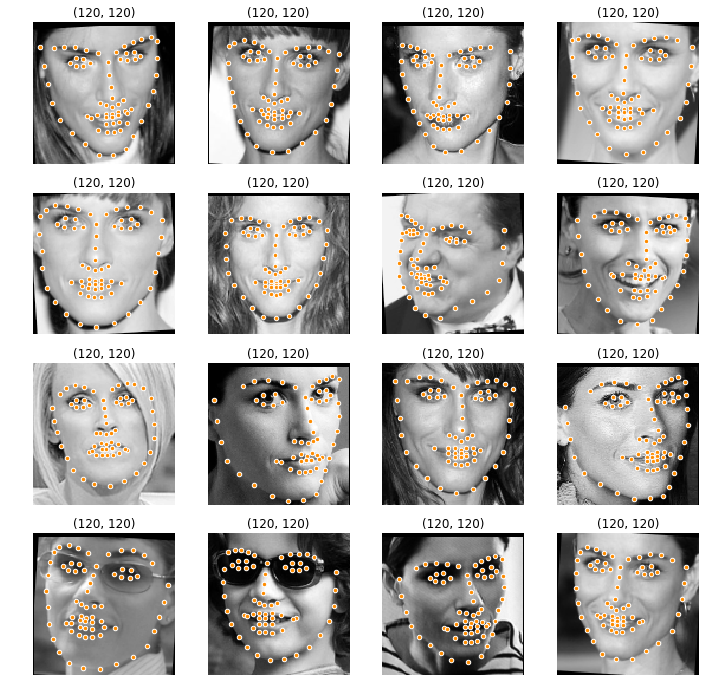

In [38]:
target_size = 120, 120
stream = AnnotatedImagesStream(root=LFPW_TRAIN, batch_size=16)
reader = FilesReader(target_size=target_size, padding=20)

cx, cy = target_size[0]/2, target_size[1]/2
rotation = Rotation(center=(cx, cy))
shift = Shift(shift_range=(-5, 5))
flip = HorizontalFlip()
gamma = GammaCorrection()
augmentation = AugmentationsList([rotation, shift, flip, gamma])

x_batch, y_batch = to_grayscale(*reader(*next(stream)))
images, points = augmentation.apply_to_batch(x_batch, y_batch)

show_images(images, points)   

In [39]:
class AnnotatedImagesGenerator:
    
    def __init__(
        self,
        root: str,
        padding: int=20,
        batch_size: int=16,
        target_size: tuple=(120, 120),
        infinite: bool=True,
        same_size_batches: bool=True,
        augment: bool=True, 
        grayscale: bool=False,
        shift_x: bool=True,
        shift_y: bool=True,
        shift_range: tuple=(-5, 5),
        rotation_range: tuple=(-10, 10),
        gamma_range: tuple=(0.5, 1.5),
        default_probability: float=0.5,
        normalize: bool=True,
        probabilities: dict=None):
        
        stream = AnnotatedImagesStream(
            root=root,
            batch_size=batch_size,
            infinite=infinite, 
            same_size_batches=same_size_batches)
        
        reader = FilesReader(
            target_size=target_size, 
            padding=padding)
        
        probs = probabilities or {}
        p = default_probability
        
        if augment:
            cx, cy = target_size[0]/2, target_size[1]/2
            rotation= Rotation(
                center=(cx, cy),
                angle_range=rotation_range,
                probability=probs.get('rotation', p))
            shift = Shift(
                shift_range=shift_range,
                shift_x=shift_x,
                shift_y=shift_y,
                probability=probs.get('shift', p))
            flip = HorizontalFlip(
                probability=probs.get('flip', p))
            gamma = GammaCorrection(
                gamma_range=gamma_range,
                probability=probs.get('gamma', p))
            augmentation = AugmentationsList([rotation, shift, flip, gamma])
        else:
            augmentation = None
        
        self.target_size = target_size
        self.stream = stream
        self.reader = reader
        self.grayscale = grayscale
        self.n_batches = stream.n_batches
        self.augment = augment
        self.normalize = normalize
        self.augmentation = augmentation
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        xy_batch = self.reader(*next(self.stream))
        if self.grayscale:
            xy_batch = to_grayscale(*xy_batch)
        if self.augment:
            xy_batch = self.augmentation.apply_to_batch(*xy_batch)
        if self.normalize:
            adjust = self.target_size[0] / 2
            x_batch, y_batch = xy_batch
            x_batch = x_batch.astype(np.float) / 255.
            y_batch = (y_batch - adjust) / adjust
            xy_batch = x_batch, y_batch
        return xy_batch

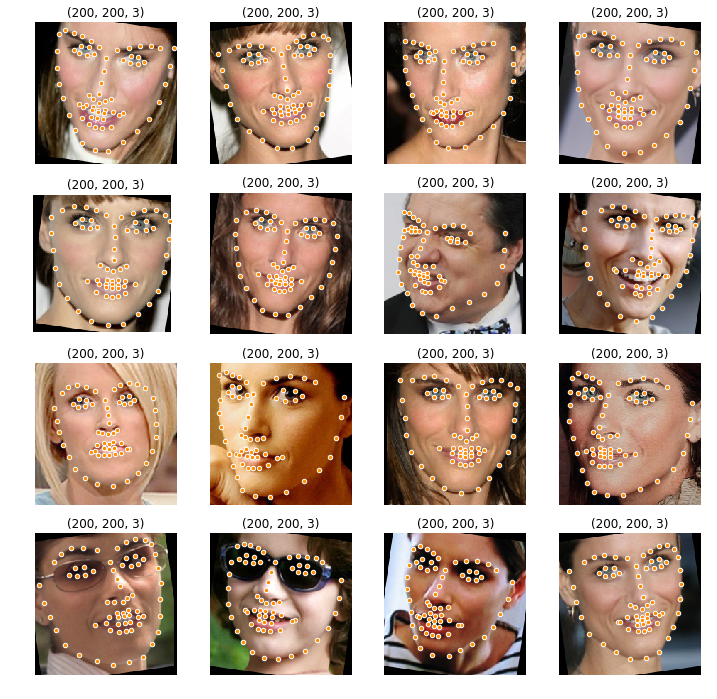

In [40]:
train_gen = AnnotatedImagesGenerator(root=LFPW_TRAIN, target_size=(200, 200), normalize=False)
sample = next(train_gen)
show_images(*sample)

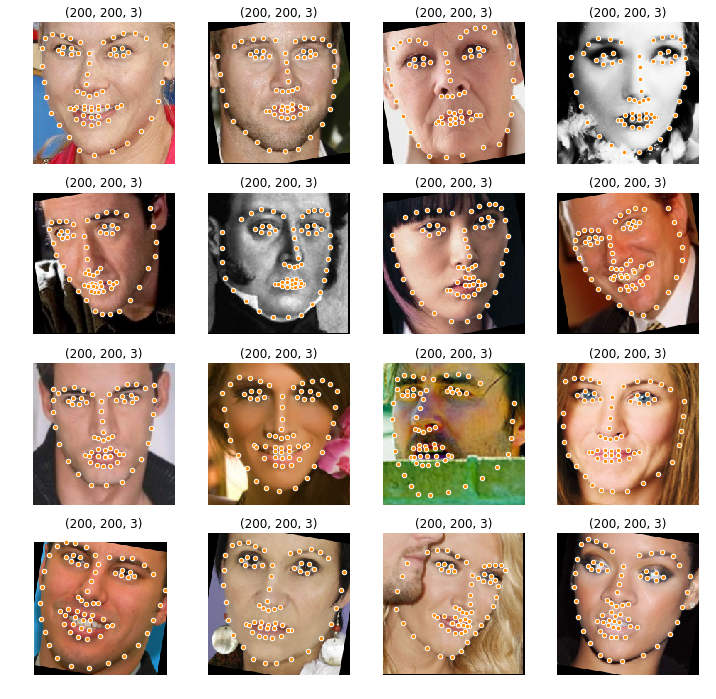

In [41]:
valid_gen = AnnotatedImagesGenerator(root=LFPW_VALID, target_size=(200, 200), normalize=False)
sample = next(valid_gen)
show_images(*sample)

Ok, now we're ready to start the training process.


### Pretrained InceptionResNetV2 

The first candidate is the `InceptionResNetV2` that has shown good results in the previous post descibing dog breeds classifier. Though now we have a regression task instead of classification.

In [68]:
import tensorflow as tf

from keras import backend as K
from keras.models import Model
from keras.constraints import MaxNorm
from keras.regularizers import l2
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten, GlobalAvgPool2D, GlobalMaxPool2D
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

In [69]:
def reset_session():
    tf.reset_default_graph()
    session = tf.InteractiveSession()
    K.set_session(session)
    K.set_image_dim_ordering('tf')

In [70]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [71]:
def create_model(
    build_fn,
    preprocess_fn, 
    input_shape,
    bn=True,
    n_dense=5,
    n_units=500,
    reg=0.001,
    output_size=NUM_OF_LANDMARKS * 2,
    top='flatten'):

    if top == 'flatten':
        top_layer = Flatten()
    elif top == 'avg':
        top_layer = GlobalAvgPool2D()
    elif top == 'max':
        top_layer = GlobalMaxPool2D()
    else:
        raise ValueError('unexpected base network top layer')

    base = build_fn(
        input_shape=input_shape, 
        weights='imagenet', 
        include_top=False)
    
    for layer in base.layers:
        layer.trainable = False

    x = top_layer(base.output)
    for _ in range(n_dense):
        x = Dense(n_units, activation='relu', kernel_regularizer=l2(reg))(x)
        if bn:
            x = BatchNormalization()(x)
    x = Dense(output_size, activation='linear', kernel_regularizer=l2(reg))(x)
    
    model = Model(inputs=base.inputs, outputs=x)
    
    return model

In [72]:
reset_session()

In [73]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

img_w = 250
img_h = 250
target_size = (img_w, img_h)
input_shape = (img_w, img_h, 3)

model = create_model(build_fn=InceptionResNetV2, 
                     preprocess_fn=preprocess_input,
                     input_shape=input_shape)

In [74]:
timestamp = datetime.now().strftime('%s')
folder = join(MODELS_FOLDER, 'face_landmarks', timestamp)
history_path = join(folder, 'history.csv')
weights_path = join(folder, 'weights_{epoch:03d}_{val_loss:2.4f}.hdf5')

In [75]:
if not exists(folder):
    os.makedirs(folder, exist_ok=True)

In [76]:
bs = 32
n_epochs = 1000

callbacks = [
    CSVLogger(filename=history_path),
    EarlyStopping(patience=500, verbose=1),
    ModelCheckpoint(filepath=weights_path,
                    save_best_only=True,
                    save_weights_only=False)]

model.compile(loss=root_mean_squared_error, optimizer='adam')

In [77]:
train_gen = AnnotatedImagesGenerator(
    root=LFPW_TRAIN, 
    batch_size=bs,
    target_size=target_size,
    augment=True)

In [78]:
valid_gen = AnnotatedImagesGenerator(
    root=LFPW_VALID, 
    batch_size=bs,
    target_size=target_size, 
    augment=False)

In [79]:
model.fit_generator(
    generator=train_gen, 
    steps_per_epoch=train_gen.n_batches,
    validation_data=valid_gen,
    validation_steps=valid_gen.n_batches,
    epochs=n_epochs, 
    callbacks=callbacks,
    shuffle=True)

Epoch 1/1000
25/25 [==============================] - 12s 468ms/step - loss: 4.1718 - val_loss: 5.5754
Epoch 2/1000
25/25 [==============================] - 8s 320ms/step - loss: 3.4716 - val_loss: 3.4048
Epoch 3/1000
25/25 [==============================] - 8s 328ms/step - loss: 2.7344 - val_loss: 2.5465
Epoch 4/1000
25/25 [==============================] - 9s 342ms/step - loss: 2.1646 - val_loss: 1.9952
Epoch 5/1000
25/25 [==============================] - 8s 333ms/step - loss: 1.7327 - val_loss: 1.4530
Epoch 6/1000
25/25 [==============================] - 8s 335ms/step - loss: 1.4291 - val_loss: 1.4574
Epoch 7/1000
25/25 [==============================] - 9s 354ms/step - loss: 1.2185 - val_loss: 1.1116
Epoch 8/1000
25/25 [==============================] - 9s 345ms/step - loss: 1.0324 - val_loss: 1.0804
Epoch 9/1000
25/25 [==============================] - 9s 341ms/step - loss: 0.9225 - val_loss: 0.8946
Epoch 10/1000
25/25 [==============================] - 9s 340ms/step - loss: 0.82

25/25 [==============================] - 9s 367ms/step - loss: 0.3024 - val_loss: 0.4755
Epoch 81/1000
25/25 [==============================] - 9s 377ms/step - loss: 0.2905 - val_loss: 0.2998
Epoch 82/1000
25/25 [==============================] - 9s 352ms/step - loss: 0.3119 - val_loss: 0.4313
Epoch 83/1000
25/25 [==============================] - 9s 367ms/step - loss: 0.3393 - val_loss: 0.5766
Epoch 84/1000
25/25 [==============================] - 9s 370ms/step - loss: 0.3144 - val_loss: 0.3672
Epoch 85/1000
25/25 [==============================] - 9s 375ms/step - loss: 0.2963 - val_loss: 0.3852
Epoch 86/1000
25/25 [==============================] - 9s 365ms/step - loss: 0.2979 - val_loss: 0.5871A: 3s - loss:  - ETA: 2s -
Epoch 87/1000
25/25 [==============================] - 9s 368ms/step - loss: 0.3019 - val_loss: 0.5417
Epoch 88/1000
25/25 [==============================] - 10s 382ms/step - loss: 0.2714 - val_loss: 0.4965
Epoch 89/1000
25/25 [==============================] - 9s 37

Epoch 159/1000
25/25 [==============================] - 9s 348ms/step - loss: 0.2266 - val_loss: 0.3294
Epoch 160/1000
25/25 [==============================] - 9s 358ms/step - loss: 0.2346 - val_loss: 0.3092
Epoch 161/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.2322 - val_loss: 0.2965
Epoch 162/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.2406 - val_loss: 0.3604
Epoch 163/1000
25/25 [==============================] - 9s 353ms/step - loss: 0.2535 - val_loss: 0.5764
Epoch 164/1000
25/25 [==============================] - 9s 350ms/step - loss: 0.2474 - val_loss: 0.2385
Epoch 165/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.2365 - val_loss: 0.3826
Epoch 166/1000
25/25 [==============================] - 9s 350ms/step - loss: 0.2351 - val_loss: 0.2820
Epoch 167/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.2185 - val_loss: 0.2281
Epoch 168/1000
25/25 [==============================] - 9s 359ms

Epoch 238/1000
25/25 [==============================] - 9s 349ms/step - loss: 0.2333 - val_loss: 0.2850
Epoch 239/1000
25/25 [==============================] - 9s 361ms/step - loss: 0.2287 - val_loss: 0.2689
Epoch 240/1000
25/25 [==============================] - 9s 365ms/step - loss: 0.2222 - val_loss: 0.3874
Epoch 241/1000
25/25 [==============================] - 9s 353ms/step - loss: 0.2368 - val_loss: 0.4435
Epoch 242/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.2253 - val_loss: 0.4116
Epoch 243/1000
25/25 [==============================] - 9s 352ms/step - loss: 0.2100 - val_loss: 0.3564
Epoch 244/1000
25/25 [==============================] - 9s 354ms/step - loss: 0.2114 - val_loss: 0.4446
Epoch 245/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.2170 - val_loss: 0.2389
Epoch 246/1000
25/25 [==============================] - 9s 359ms/step - loss: 0.2568 - val_loss: 0.3325
Epoch 247/1000
25/25 [==============================] - 9s 355ms

25/25 [==============================] - 9s 365ms/step - loss: 0.2028 - val_loss: 0.3494
Epoch 317/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.1964 - val_loss: 0.5203
Epoch 318/1000
25/25 [==============================] - 9s 359ms/step - loss: 0.1837 - val_loss: 0.3005
Epoch 319/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1928 - val_loss: 0.2516
Epoch 320/1000
25/25 [==============================] - 9s 352ms/step - loss: 0.1853 - val_loss: 0.2160
Epoch 321/1000
25/25 [==============================] - 9s 363ms/step - loss: 0.1920 - val_loss: 0.4775
Epoch 322/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.1956 - val_loss: 0.2633
Epoch 323/1000
25/25 [==============================] - 9s 363ms/step - loss: 0.2044 - val_loss: 0.3414
Epoch 324/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1935 - val_loss: 0.3433
Epoch 325/1000
25/25 [==============================] - 9s 361ms/step - loss: 0

Epoch 395/1000
25/25 [==============================] - 9s 353ms/step - loss: 0.1950 - val_loss: 0.3123
Epoch 396/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.1847 - val_loss: 0.3441
Epoch 397/1000
25/25 [==============================] - 9s 355ms/step - loss: 0.1821 - val_loss: 0.4166
Epoch 398/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1753 - val_loss: 0.4742
Epoch 399/1000
25/25 [==============================] - 9s 363ms/step - loss: 0.1827 - val_loss: 0.5881
Epoch 400/1000
25/25 [==============================] - 9s 363ms/step - loss: 0.1937 - val_loss: 0.3017
Epoch 401/1000
25/25 [==============================] - 9s 361ms/step - loss: 0.1865 - val_loss: 0.2531
Epoch 402/1000
25/25 [==============================] - 9s 349ms/step - loss: 0.1878 - val_loss: 0.2436
Epoch 403/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1870 - val_loss: 0.3769
Epoch 404/1000
25/25 [==============================] - 9s 353ms

Epoch 474/1000
25/25 [==============================] - 9s 351ms/step - loss: 0.1694 - val_loss: 0.2451
Epoch 475/1000
25/25 [==============================] - 9s 370ms/step - loss: 0.1811 - val_loss: 0.2274
Epoch 476/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1826 - val_loss: 0.3674
Epoch 477/1000
25/25 [==============================] - 9s 367ms/step - loss: 0.1764 - val_loss: 0.1908
Epoch 478/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.1721 - val_loss: 0.1933
Epoch 479/1000
25/25 [==============================] - 9s 355ms/step - loss: 0.1808 - val_loss: 0.2117
Epoch 480/1000
25/25 [==============================] - 9s 359ms/step - loss: 0.1749 - val_loss: 0.2996
Epoch 481/1000
25/25 [==============================] - 9s 365ms/step - loss: 0.1835 - val_loss: 0.3761
Epoch 482/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.2025 - val_loss: 0.3138
Epoch 483/1000
25/25 [==============================] - 9s 355ms

Epoch 553/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1650 - val_loss: 0.1794
Epoch 554/1000
25/25 [==============================] - 9s 366ms/step - loss: 0.1616 - val_loss: 0.2325
Epoch 555/1000
25/25 [==============================] - 9s 359ms/step - loss: 0.1706 - val_loss: 0.2225
Epoch 556/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1745 - val_loss: 0.2337
Epoch 557/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.1720 - val_loss: 0.2815
Epoch 558/1000
25/25 [==============================] - 9s 354ms/step - loss: 0.1680 - val_loss: 0.2648
Epoch 559/1000
25/25 [==============================] - 9s 365ms/step - loss: 0.1656 - val_loss: 0.3695
Epoch 560/1000
25/25 [==============================] - 9s 361ms/step - loss: 0.1809 - val_loss: 0.1663
Epoch 561/1000
25/25 [==============================] - 9s 366ms/step - loss: 0.1758 - val_loss: 0.2311
Epoch 562/1000
25/25 [==============================] - 9s 357ms

Epoch 632/1000
25/25 [==============================] - 9s 364ms/step - loss: 0.1712 - val_loss: 0.3138
Epoch 633/1000
25/25 [==============================] - 9s 354ms/step - loss: 0.1864 - val_loss: 0.2676
Epoch 634/1000
25/25 [==============================] - 9s 370ms/step - loss: 0.1852 - val_loss: 0.1739
Epoch 635/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1849 - val_loss: 0.4389
Epoch 636/1000
25/25 [==============================] - 9s 357ms/step - loss: 0.1774 - val_loss: 0.3680
Epoch 637/1000
25/25 [==============================] - 9s 364ms/step - loss: 0.1783 - val_loss: 0.2597
Epoch 638/1000
25/25 [==============================] - 9s 366ms/step - loss: 0.1830 - val_loss: 0.2676
Epoch 639/1000
25/25 [==============================] - 9s 363ms/step - loss: 0.1761 - val_loss: 0.2433
Epoch 640/1000
25/25 [==============================] - 9s 353ms/step - loss: 0.1740 - val_loss: 0.3750
Epoch 641/1000
25/25 [==============================] - 9s 375ms

25/25 [==============================] - 9s 378ms/step - loss: 0.1744 - val_loss: 0.1911
Epoch 711/1000
25/25 [==============================] - 10s 393ms/step - loss: 0.1682 - val_loss: 0.1898
Epoch 712/1000
25/25 [==============================] - 10s 380ms/step - loss: 0.1779 - val_loss: 0.1822
Epoch 713/1000
25/25 [==============================] - 10s 386ms/step - loss: 0.1640 - val_loss: 0.1766
Epoch 714/1000
25/25 [==============================] - 10s 382ms/step - loss: 0.1846 - val_loss: 0.2359
Epoch 715/1000
25/25 [==============================] - 10s 387ms/step - loss: 0.1829 - val_loss: 0.4063
Epoch 716/1000
25/25 [==============================] - 9s 378ms/step - loss: 0.1684 - val_loss: 0.2576
Epoch 717/1000
25/25 [==============================] - 9s 377ms/step - loss: 0.1708 - val_loss: 0.2550
Epoch 718/1000
25/25 [==============================] - 10s 392ms/step - loss: 0.1763 - val_loss: 0.1841
Epoch 719/1000
25/25 [==============================] - 9s 374ms/step - l

Epoch 789/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1851 - val_loss: 0.2540
Epoch 790/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1658 - val_loss: 0.3221
Epoch 791/1000
25/25 [==============================] - 9s 367ms/step - loss: 0.1781 - val_loss: 0.2124
Epoch 792/1000
25/25 [==============================] - 9s 360ms/step - loss: 0.1717 - val_loss: 0.4599
Epoch 793/1000
25/25 [==============================] - 9s 355ms/step - loss: 0.1725 - val_loss: 0.3242
Epoch 794/1000
25/25 [==============================] - 9s 356ms/step - loss: 0.1869 - val_loss: 0.2502
Epoch 795/1000
25/25 [==============================] - 9s 364ms/step - loss: 0.1819 - val_loss: 0.3739
Epoch 796/1000
25/25 [==============================] - 9s 362ms/step - loss: 0.1769 - val_loss: 0.2250
Epoch 797/1000
25/25 [==============================] - 9s 359ms/step - loss: 0.1720 - val_loss: 0.3409
Epoch 798/1000
25/25 [==============================] - 9s 363ms

KeyboardInterrupt: 